# Excercises 10b for Section 10.3

## 1

If the regression matrix contains the intercept column, then $\sum_i(x_{ij}-\overline{x}_j)e_j=0$ for all $j$ for residuals $e_j$. This follows from normal conditions on a residual, $X^\top\hat Y=X^\top(I-P)Y=0$.

Then, the partial residual plot regressing $e_{ij}^\dagger =e_i+\hat\beta x_{ij}$ is just an OLS with an error term $e_i$ which is mean-0 with respect to the explanatory variable.

## 2

### (a)

Generate 100 samples from the model $Y=1+X_1+2\mathrm{sgn} (X_2)\left|X_2\right|^{1/3}+\varepsilon$ where $\varepsilon\sim N(0,\sigma^2),\sigma=0.25$ and $X_i$ are iid standard normal.

We can, more-or-less, notice a cubic pattern in the partial residual plot

In [1]:
import numpy as np
np.random.seed(1234)

sigma = 0.25
n = 100
eps = np.random.normal(size=n) * sigma
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
y = 1 + x1 + 2 * np.sign(x2) * np.abs(x2) ** (1/3) + eps

### (b)

Construct a partial residual plot for $X_2$

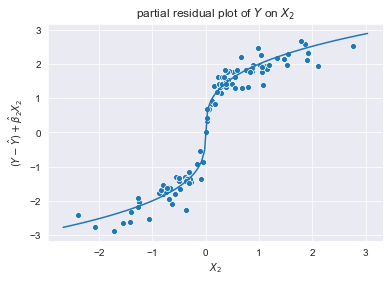

In [2]:
X = np.column_stack([np.ones(n), x1, x2])
beta, rss, rank, s = np.linalg.lstsq(X, y, rcond=None)
assert rank == 3, rank
res = y - X.dot(beta)

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# if the relationship is Y ~ X1 + g(X2)
# then the linear model fit is Y = beta0 + beta1 X1 + beta2 X2 + (g(X2) - beta2 X2)
# heuristically (this only works if g(X2) is orthogonal to X1 residuals)
partial_residual = res + beta[2] * x2

sns.scatterplot(x2, partial_residual)
plt.xlabel(r'$X_2$')
plt.ylabel(r'$(Y-\hat Y) + \hat\beta_2 X_2$')
plt.title('partial residual plot of $Y$ on $X_2$')

xlo, xhi = plt.xlim()
xs = np.linspace(xlo, xhi, 100)
plt.plot(xs, 2 * np.sign(xs) * np.abs(xs) ** (1/3))

plt.show()

## (c)

Now let's correlate $X_1,X_2$ by $\rho=0.95$ ($0.99$ for emphasis)

In [3]:
rho = 0.99
x2corr = rho * x1 + np.sqrt(1 - rho ** 2) * x2
ycorr = 1 + x1 + 2 * np.sign(x2corr) * np.abs(x2corr) ** (1/3) + eps

## (d)

Let's build an analogous plot

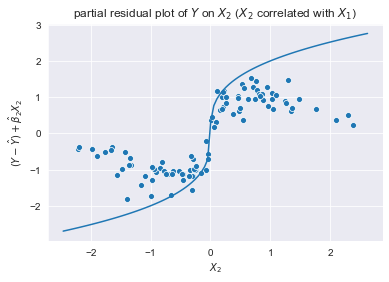

In [4]:
X = np.column_stack([np.ones(n), x1, x2corr])
beta, rss, rank, s = np.linalg.lstsq(X, ycorr, rcond=None)
assert rank == 3, rank
res = ycorr - X.dot(beta)

partial_residual = res + beta[2] * x2corr

sns.scatterplot(x2corr, partial_residual)
plt.xlabel(r'$X_2$')
plt.ylabel(r'$(Y-\hat Y) + \hat\beta_2 X_2$')
plt.title(r'partial residual plot of $Y$ on $X_2$ ($X_2$ correlated with $X_1$)')

xlo, xhi = plt.xlim()
xs = np.linspace(xlo, xhi, 100)
plt.plot(xs, 2 * np.sign(xs) * np.abs(xs) ** (1/3))
plt.show()

## (d)

As described in the comment above, only when the regression of the partial residual plot covariate $X_2$ on the remaining covariates $1,X_1$ is small do we see the cubic trend more clearly (correlating $X_1$ and $X_2$ counterintuitively de-correlates $X_1,X_2^{1/3}$ because the correlation between $X_1,X_1^{1/3}$ is larger than that of $X_1,X_2^{1/3}$, a fact that can be seen by the integrals below.

In [5]:
cov = np.array([[1, rho], [rho, 1]])

from scipy.linalg import sqrtm

idet = 1 / np.linalg.det(cov)
A = sqrtm(cov)

import quadpy

def f(z):
    # Z ~ N(0, cov)
    return (z[0] * np.sign(z[1]) * np.abs(z[1]) ** (1/3))

def integrand(y):
    # z ~ N(0, cov), x ~ N(0, I)
    # want integrand p(z) f(z)
    #
    # z = Ax, A = sqrt(cov)
    #
    # by change of variables into x
    # |cov|^{1/2} p(z(x)) f(z(x))
    # where z(x) = Ax
    #
    # have exp(-||x||**2)
    # 
    # p(z) == (2pi)^(-dim/2)*|cov|^{-1/2}exp(-1/2 (z^T (cov)^-1 z))
    # |cov|^{1/2} p(z) == (2pi)^(-dim/2) * exp(-1/2 ||x||**2)
    #
    # need another change of variables x = y * sqrt(2)
    # by change of variables |det Dx(y)|= sqrt(2)^dim
    return (np.pi) ** (-len(y) / 2) * f(A.dot(y * np.sqrt(2)))

scheme = quadpy.e2r2.rabinowitz_richter_3()
scheme.integrate(integrand)

0.8374014410269036

In [6]:
X = np.column_stack([np.ones(n), x1])
for coef in ['x2', 'x2corr']:
    _, rss, _, _ = np.linalg.lstsq(X, eval(coef), rcond=None)
    r2 = 1 - rss.item() / np.var(x2) / n
    print('coef', coef, 'r2 on [1,x1]', r2)

coef x2 r2 on [1,x1] 0.015403770442360631
coef x2corr r2 on [1,x1] 0.980406535031803


# 3

Partial residual plots are vulnerable to correlations

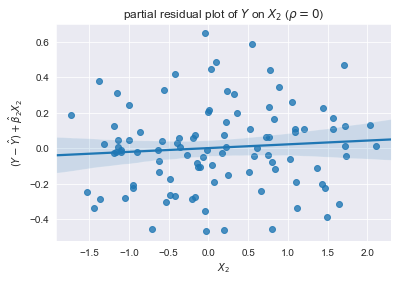

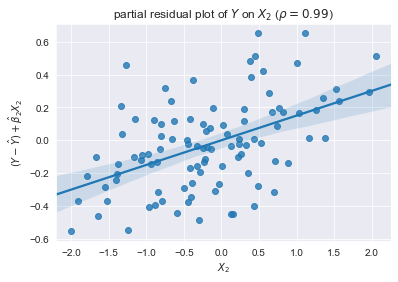

In [7]:
eps = np.random.normal(size=n) * sigma
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
for rho in [0, 0.99]:
    sigma = 0.25
    n = 100
    x2c = rho * x1 + np.sqrt(1 - rho ** 2) * x2
    y = 1 + x1 + eps
    
    X = np.column_stack([np.ones(n), x1, x2c])
    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    res = y - X.dot(beta)

    partial_residual = res + beta[2] * x2c

    sns.regplot(x2c, partial_residual)
    plt.xlabel(r'$X_2$')
    plt.ylabel(r'$(Y-\hat Y) + \hat\beta_2 X_2$')
    plt.title(r'partial residual plot of $Y$ on $X_2$ ($\rho = {}$)'.format(rho))

    plt.show()

# 4

Added variable plots are less vulnerable, where a null coefficient looks the same regardless of correlation.

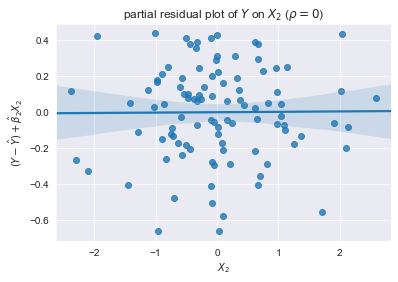

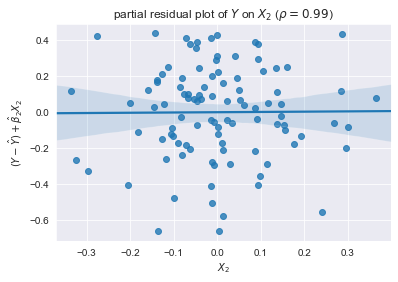

In [8]:
eps = np.random.normal(size=n) * sigma
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)

for rho in [0, 0.99]:
    x2c = rho * x1 + np.sqrt(1 - rho ** 2) * x2
    y = 1 + x1 + eps
    
    X = np.column_stack([np.ones(n), x1])
    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    res = y - X.dot(beta)
    
    beta2, _, _, _ = np.linalg.lstsq(X, x2c, rcond=None)
    x2res = x2c - X.dot(beta2)

    sns.regplot(x2res, res)#, lowess=True)
    plt.xlabel(r'$X_2$')
    plt.ylabel(r'$(Y-\hat Y) + \hat\beta_2 X_2$')
    plt.title(r'partial residual plot of $Y$ on $X_2$ ($\rho = {}$)'.format(rho))

    plt.show()

# 5

Nonlinear dependencies should also in principle make partial residual plots "fail to expose" the true nonlinearity. We show weak linear dep (correlation) and nonlinear dep's effects.

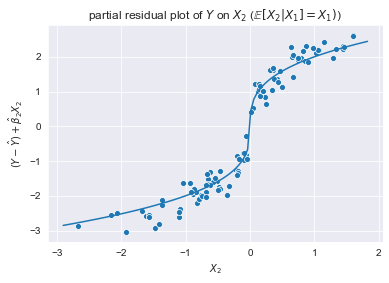

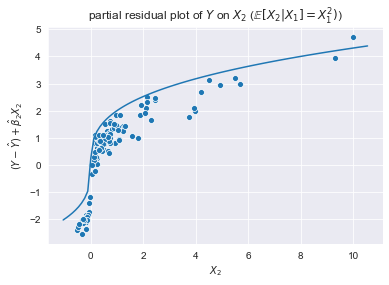

In [9]:
for nm, nonlin in zip(['', '^2'], [lambda x: x, lambda x: x * x]):
    sigma = 0.25
    n = 100
    eps = np.random.normal(size=n) * sigma
    x1 = np.random.normal(size=n)
    u = np.random.normal(size=n) * np.sqrt(0.1)
    x2 = nonlin(x1) + u
    y = 1 + x1 + 2 * np.sign(x2) * np.abs(x2) ** (1/3) + eps
    
    X = np.column_stack([np.ones(n), x1, x2])
    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    res = y - X.dot(beta)

    partial_residual = res + beta[2] * x2

    sns.scatterplot(x2, partial_residual)
    plt.xlabel(r'$X_2$')
    plt.ylabel(r'$(Y-\hat Y) + \hat\beta_2 X_2$')
    plt.title(r'partial residual plot of $Y$ on $X_2$ ($\mathbb{{E}}[X_2|X_1]=X_1{})$)'.format(nm))

    xlo, xhi = plt.xlim()
    xs = np.linspace(xlo, xhi, 100)
    plt.plot(xs, 2 * np.sign(xs) * np.abs(xs) ** (1/3))
    plt.show()

    plt.show()